Neural network solving SEIR model.
Based on code by Rui Wang.

In [1]:
import torch 
import numpy as np
import torch.nn as nn
from scipy.integrate import odeint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"
#device = torch.device("cpu")
print(device)
import matplotlib.pyplot as plt
from tqdm import tqdm

cuda


# Read Data

In [2]:
SIR=torch.load("SIR_data_SD_county.pt")

In [3]:
#normalization 
npop=SIR[0,0].numpy().copy()
print("Total population: %d" % npop)
SIR[:,:] = SIR[:,:] / npop

Total population: 3338330


In [4]:
#%%writefile seir.py
class Neural_ODE_SEIR(nn.Module):
    def __init__(self, solver = "Euler", initial='random'):
        super(Neural_ODE_SEIR, self).__init__()
        if initial == 'random':
            self.initial = torch.nn.Parameter(torch.rand(4)/10)
        else:
            self.initial = torch.nn.Parameter(initial)
        
        #print(self.initial)
            
        nt=500
        #self.beta = torch.nn.Parameter(torch.rand(nt)/10)
        #self.gamma = torch.nn.Parameter(torch.rand(nt)/10)
        #self.sigma = torch.nn.Parameter(torch.rand(nt)/10)
        self.beta = torch.nn.Parameter(torch.ones(nt)*0.05)
        self.gamma = torch.nn.Parameter(torch.ones(nt)*0.09)
        self.sigma = torch.nn.Parameter(torch.ones(nt)*0.04)
        self.step = torch.tensor(1)
        self.solver = solver
        
    def Euler(self, t):
        S_pred = [self.initial[0].reshape(-1,1)]
        E_pred = [self.initial[1].reshape(-1,1)]
        I_pred = [self.initial[2].reshape(-1,1)]
        R_pred = [self.initial[3].reshape(-1,1)]
        for n in range(len(t)-1):
            S_pred.append((S_pred[n] - self.beta[n][n]*S_pred[n]*I_pred[n]*self.step).reshape(-1,1))
            E_pred.append((E_pred[n] + (self.beta[n]*S_pred[n]*I_pred[n] - self.sigma[n]*E_pred[n])*self.step).reshape(-1,1))
            I_pred.append((I_pred[n] + (self.sigma[n]*E_pred[n] - self.gamma[n]*I_pred[n])*self.step).reshape(-1,1))
            R_pred.append((R_pred[n] + self.gamma[n]*I_pred[n]*self.step).reshape(-1,1))
        y_pred = torch.cat([torch.cat(S_pred, dim = 0),
                            #torch.cat(E_pred, dim = 0),
                            torch.cat(I_pred, dim = 0), 
                            torch.cat(R_pred, dim = 0)], dim = 1)
        return y_pred
    
    def RK4(self, t):
        S_pred = [self.initial[0].reshape(-1,1)]
        E_pred = [self.initial[1].reshape(-1,1)]
        I_pred = [self.initial[2].reshape(-1,1)]
        R_pred = [self.initial[3].reshape(-1,1)]
        
        for n in range(len(t)-1):
            k1 = self.beta[n]*S_pred[n]*I_pred[n]*self.step #dt * f(t[n], y[n]) 
            k2 = (self.beta[n]*(S_pred[n]+ k1/2)*I_pred[n])*self.step #dt * f(t[n] + dt/2, y[n] + k1/2)
            k3 = (self.beta[n]*(S_pred[n]+ k2/2)*I_pred[n])*self.step #dt * f(t[n] + dt/2, y[n] + k2/2)
            k4 = (self.beta[n]*(S_pred[n]+ k3)*I_pred[n])*self.step #dt * f(t[n] + dt, y[n] + k3)            
            S_pred.append((S_pred[n] - 1/6 * (k1 + 2*k2 + 2*k3 + k4)).reshape(-1,1))
            
            k1 = (self.beta[n]*S_pred[n]*I_pred[n] - self.sigma[n]*E_pred[n])*self.step #dt * f(t[n], y[n]) 
            k2 = (self.beta[n]*S_pred[n]*I_pred[n] - self.sigma[n]*(E_pred[n] +  k1/2))*self.step #dt * f(t[n] + dt/2, y[n] + k1/2)
            k3 = (self.beta[n]*S_pred[n]*I_pred[n] - self.sigma[n]*(E_pred[n] +  k2/2))*self.step #dt * f(t[n] + dt/2, y[n] + k2/2)
            k4 = (self.beta[n]*S_pred[n]*I_pred[n] - self.sigma[n]*(E_pred[n] +  k3))*self.step #dt * f(t[n] + dt, y[n] + k3)            
            E_pred.append((E_pred[n] + 1/6 * (k1 + 2*k2 + 2*k3 + k4)).reshape(-1,1))
            
            k1 = (self.sigma[n]*E_pred[n] - self.gamma[n]*I_pred[n])*self.step #dt * f(t[n], y[n]) 
            k2 = (self.sigma[n]*E_pred[n] - self.gamma[n]*(I_pred[n] + k1/2))*self.step #dt * f(t[n] + dt/2, y[n] + k1/2)
            k3 = (self.sigma[n]*E_pred[n] - self.gamma[n]*(I_pred[n] + k2/2))*self.step #dt * f(t[n] + dt/2, y[n] + k2/2)
            k4 = (self.sigma[n]*E_pred[n] - self.gamma[n]*(I_pred[n] + k3))*self.step #dt * f(t[n] + dt, y[n] + k3)   
            I_pred.append((I_pred[n] + 1/6 * (k1 + 2*k2 + 2*k3 + k4)).reshape(-1,1))
            
            R_pred.append((R_pred[n] + self.gamma[n]*I_pred[n]*self.step).reshape(-1,1))

        y_pred = torch.cat([torch.cat(S_pred, dim = 0), 
                            #torch.cat(E_pred, dim = 0),
                            torch.cat(I_pred, dim = 0), 
                            torch.cat(R_pred, dim = 0)], dim = 1)
        return y_pred
            
            
    def forward(self, t):
        if self.solver == "Euler":
            return self.Euler(t)
        elif self.solver == "RK4":
            return self.RK4(t)
        else:
            print("Error")        

In [5]:
t0=0
t1=380

time = torch.tensor(np.linspace(0, len(SIR)-1, len(SIR)), requires_grad=True).float()#.cuda()
myinit=torch.cat([SIR[t0,0].reshape(-1,1), 
                  (SIR[t0,1]*2).reshape(-1,1), 
                  SIR[t0,1].reshape(-1,1), 
                  SIR[t0,2].reshape(-1,1)])
#print(myinit)
model_ode_seir = Neural_ODE_SEIR(solver = "RK4", initial=myinit)#.cuda()
y_exact = SIR.float()#.cuda()

optimizer = torch.optim.Adam(model_ode_seir.parameters(), 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.95)
num_epochs = 300
loss_fun = torch.nn.MSELoss()
tqdm_epochs = tqdm(range(num_epochs))
min_loss = 10

for e in tqdm_epochs:
    y_approx = model_ode_seir(time[t0:t1])
    loss = loss_fun(y_approx, y_exact[t0:t1])
    if loss.item() < min_loss:
        best_model_ode_seir = model_ode_seir
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()})

100%|██████████| 300/300 [04:24<00:00,  1.13it/s, loss=2.35e-7]


In [6]:
#torch.nn.Parameter(torch.cat([SIR[t0,0].reshape(-1,1), SIR[t0,1].reshape(-1,1)]))

In [7]:
beta=best_model_ode_seir.beta.detach().numpy()
gamma=best_model_ode_seir.gamma.detach().numpy()
sigma=best_model_ode_seir.sigma.detach().numpy()
print("Beta:", beta)
#,gamma,sigma)

Beta: [0.04111129 0.04132488 0.04153785 0.04174995 0.04196087 0.04217057
 0.04237877 0.04258558 0.04279096 0.04299484 0.04319735 0.04339862
 0.04359885 0.04379807 0.04399659 0.04419457 0.04439219 0.04458971
 0.04478728 0.04498516 0.04518351 0.0453826  0.04558251 0.04578344
 0.04598564 0.0461892  0.04639423 0.04660097 0.04680938 0.04701974
 0.04723208 0.04744649 0.04766302 0.04788177 0.04810278 0.04832622
 0.04855207 0.04878038 0.04901136 0.04924506 0.04948169 0.04972159
 0.04996428 0.05020976 0.05045815 0.05070942 0.05096354 0.05122046
 0.05148016 0.05174262 0.05200779 0.05227547 0.05254572 0.05281844
 0.05309333 0.05337052 0.05365004 0.0539317  0.05421509 0.05450072
 0.05478811 0.05507722 0.0553681  0.05566074 0.05595488 0.05625027
 0.05654686 0.05684457 0.05714357 0.05744344 0.05774356 0.05804409
 0.05834484 0.05864552 0.05894643 0.05924736 0.05954843 0.05984992
 0.06015144 0.06045278 0.06075399 0.06105513 0.06135623 0.06165731
 0.06195772 0.06225757 0.06255669 0.06285517 0.06315299 

In [8]:
import pandas as pd
dates=pd.date_range(start='2020-1-22', periods=500, freq='D')

<IPython.core.display.Javascript object>


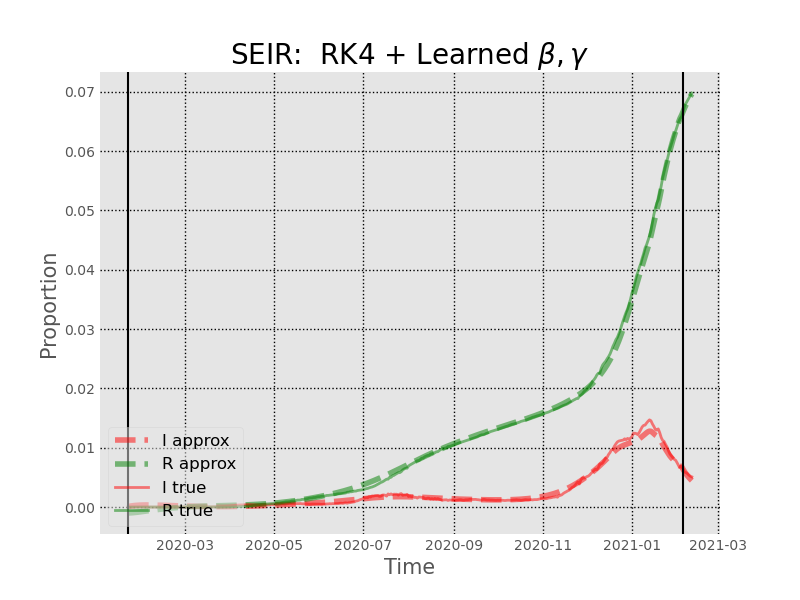

In [9]:
%matplotlib notebook

#plt.style.use('dark_background')
plt.style.use('ggplot')
x = np.linspace(0, len(SIR)-1, len(SIR))
fig=plt.figure(figsize=(8, 6))#, facecolor='lightgray')
ax = fig.add_subplot(111, #facecolor=fcolor, 
                     axisbelow=True) #'#dddddd'

t2=387 #end of prediction window
y_pred = best_model_ode_seir(time[t0:t2])
#ax.plot(x[t0:t2], y_pred[:,0].cpu().data.numpy(), 'y', alpha=0.5, lw=4, linestyle = "--", label='S approx')
ax.plot(dates[t0:t2], y_pred[:,1].cpu().data.numpy(), 'r', alpha=0.5, lw=4, linestyle = "--", label='I approx')
ax.plot(dates[t0:t2], y_pred[:,2].cpu().data.numpy(), 'g', alpha=0.5, lw=4, linestyle = "--", label='R approx')

#ax.plot(x, y_exact[:,0].cpu().data.numpy(), 'y', alpha=0.5, lw=2,  label='S true')
ax.plot(dates[t0:t2], y_exact[t0:t2,1].cpu().data.numpy(), 'r', alpha=0.5, lw=2,  label='I true')
ax.plot(dates[t0:t2], y_exact[t0:t2,2].cpu().data.numpy(), 'g', alpha=0.5, lw=2,  label='R true')
ax.axvline(dates[t1], color = "black")
ax.axvline(dates[t0], color = "black")
ax.set_xlabel('Time', size = 15)
ax.set_ylabel('Proportion', size = 15)
#ax.set_ylim(-0.1,1.2)
#ax.set_xlim(t0-(t1-t0),t2+1)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='k', lw=1, ls=':')
legend = ax.legend(fontsize = 12, loc = 3)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title("SEIR:  RK4 + Learned " + r"$\beta, \gamma$", size = 20)#
#plt.savefig("SIR_NeuralODE_RK4.png", dpi = 400 , bbox_inches = "tight")
#plt.text(0.10, 0.7, '$\\beta = %5.3f$' % beta, fontsize=14, transform=ax.transAxes)
#plt.text(0.10, 0.6, '$\\gamma = %5.3f$' % gamma, fontsize=14, transform=ax.transAxes)
plt.show()
#fig.savefig("seir_pde.png", transparent=False)

In [10]:
import pandas as pd
dates=pd.date_range(start='2020-1-22', periods=500, freq='D')

<IPython.core.display.Javascript object>


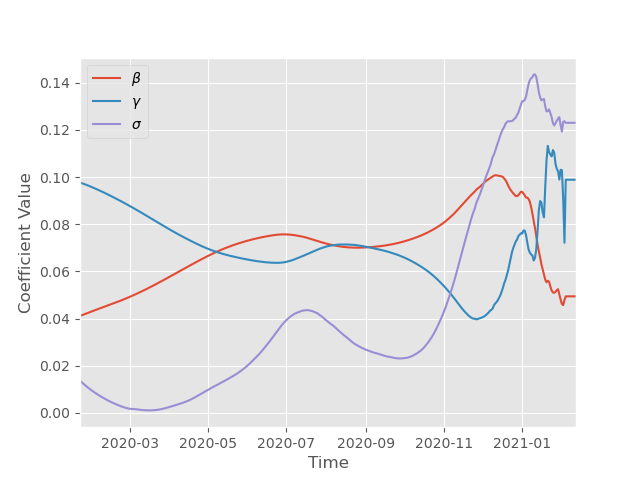

Text(0, 0.5, 'Coefficient Value')

In [11]:
tm=t1-10
beta[t1-1:] = np.mean(beta[tm:t1-1])
gamma[t1-1:] = np.mean(gamma[tm:t1-1])
sigma[t1-1:] = np.mean(sigma[tm:t1-1])
fig2,ax2=plt.subplots()
ax2.plot(dates[0:t2], beta[0:t2], label="$\\beta$")
ax2.plot(dates[0:t2], gamma[0:t2], label="$\\gamma$")
ax2.plot(dates[0:t2], sigma[0:t2], label="$\\sigma$")
ax2.legend(loc="upper left")
ax2.set_xlim(dates[t0],dates[t2])
ax2.set_xlabel('Time')
ax2.set_ylabel('Coefficient Value')